### Makes gym environment instance

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym

import unity_env
import cube_agent

In [2]:
# Makes an environment instance
env = gym.make("UnityEnv-v1")

# Training

In [5]:
# Starts Socket Communication with Unity
connection_result = env.unwrapped.connect_and_check_unity()
if not connection_result:
    print("It seems Unity has been disconnected. Gym env will be closed.")
    env.close()

Successfully connected to Unity!


In [ ]:
# Define hyperparameters.
learning_rate = 0.01
n_episodes = 500
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

# Instantiate the agent with the predefined environment and hyperparameters.
agent = cube_agent.CubeAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Wrap the environment to record and track episode statistics.
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# Train the agent for a predefined number of episodes.
# The tqdm library provides a progress bar to visualize the iteration progress.
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()  # Reset the environment and retrieve the initial observation.
    done = False

    # Execute one episode until termination or truncation.
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # Uncomment to render the environment.
        # env.render() 

        # Update the agent's knowledge.
        agent.update(obs, action, reward, terminated, next_obs)

        # Check if the episode has ended and update the current observation.
        done = terminated or truncated
        obs = next_obs

    # Decay the exploration rate after each episode.
    agent.decay_epsilon()

# Notify Unity that the training is complete, prompting it to exit play mode or shut down the built application.
env.sendMessageToUnityTrainingIsOver()

# Also close the environment defined in Python.
env.close()

/opt/anaconda3/envs/abess/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/500 [00:00<?, ?it/s]/opt/anaconda3/envs/abess/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/opt/anaconda3/envs/abess/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
 26%|██▌       | 130/500 [01:16<05:59,  1.03it/s]

### VISUALIZING THE TRAINING

In [21]:
# TODO: Autosaving training results and visualizing via autosaved file.

/opt/anaconda3/envs/abess/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.episode_rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_rewards` for environment variables or `env.get_attr('episode_rewards')` that will search the reminding wrappers.
  logger.warn(


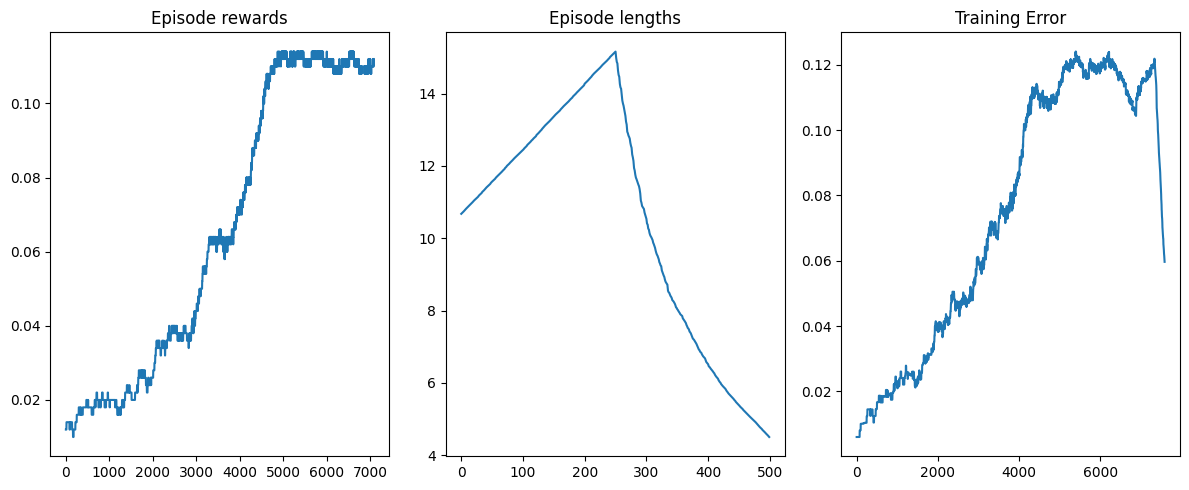

In [19]:
rolling_length = 500

# Setting up subplots to display three graphs side by side.
# Using 'ncols=3' to arrange the graphs in three columns, and 'figsize' to specify the figure size.
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# First Graph: Episode Rewards
axs[0].set_title("Episode Rewards")  # Setting the title for the graph.
# Compute the moving average of the episode rewards to smooth out the visualization.
reward_moving_average = (
    np.convolve(
        np.array(env.episode_rewards).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
# Plotting the moving average data on the first subplot.
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Second Graph: Episode Lengths
axs[1].set_title("Episode Lengths")  # Setting the title for the graph.
# Compute the moving average of the episode lengths.
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
# Plotting the moving average data on the second subplot.
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# Third Graph: Training Error
axs[2].set_title("Training Error")  # Setting the title for the graph.
# Compute the moving average of the training error.
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
# Plotting the moving average data on the third subplot.
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

# Automatically adjust the layout to prevent overlap between graphs.
plt.tight_layout()
# Display the plotted graphs.
plt.show()


visualizing policy

/opt/anaconda3/envs/abess/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.goal_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.goal_pos` for environment variables or `env.get_attr('goal_pos')` that will search the reminding wrappers.
  logger.warn(


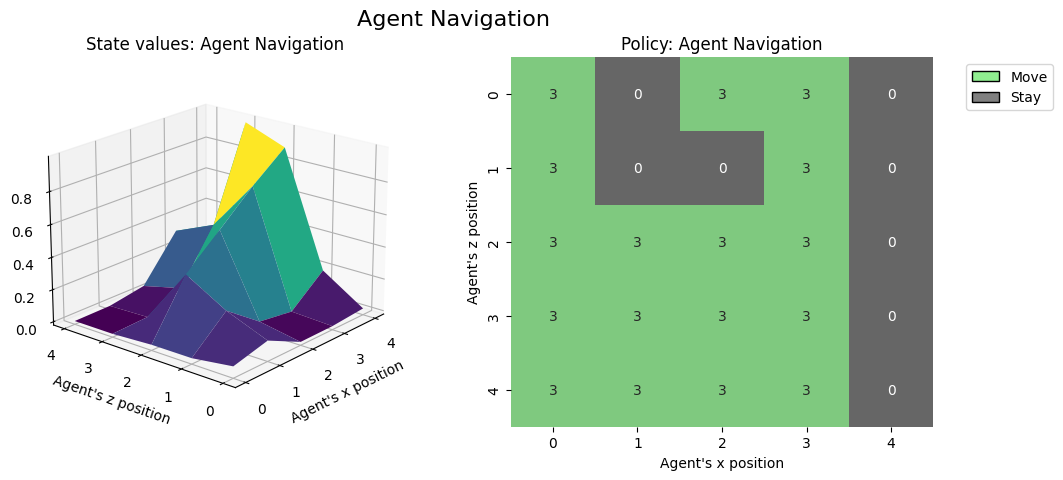

In [20]:
def create_grids(env, agent):
    """Create value and policy grids given an agent."""
    # Compute state-value and build a policy dictionary mapping observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    x_range, z_range = np.meshgrid(
        # Agent's x and z position
        np.arange(0, 5),
        np.arange(0, 5),
    )

    # Create a value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], env.goal_pos[0], env.goal_pos[1])],
        axis=2,
        arr=np.dstack([x_range, z_range]),
    )
    value_grid = x_range, z_range, value

    # Create a policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], env.goal_pos[0], env.goal_pos[1])],
        axis=2,
        arr=np.dstack([x_range, z_range]),
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    """Create graphs using a value and policy grid."""
    # Create a new figure with 2 subplots (left: state values, right: policy)
    x_range, z_range, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # Plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        x_range,
        z_range,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0, 5), range(0, 5))
    plt.yticks(range(0, 5), range(0, 5))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Agent's x position")
    ax1.set_ylabel("Agent's z position")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # Plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Agent's x position")
    ax2.set_ylabel("Agent's z position")
    ax2.set_xticklabels(range(0, 5))
    ax2.set_yticklabels(range(0, 5))

    # Add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Move"),
        Patch(facecolor="grey", edgecolor="black", label="Stay"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

# State values & policy for the given environment and agent
value_grid, policy_grid = create_grids(env, agent)
fig1 = create_plots(value_grid, policy_grid, title="Agent Navigation")
plt.show()